In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
import lime.lime_tabular_mod as lime_tab
import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
104,6.5,3.0,5.8,2.2,Iris-virginica
21,5.1,3.7,1.5,0.4,Iris-setosa
35,5.0,3.2,1.2,0.2,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
...,...,...,...,...,...
43,5.0,3.5,1.6,0.6,Iris-setosa
67,5.8,2.7,4.1,1.0,Iris-versicolor
77,6.7,3.0,5.0,1.7,Iris-versicolor
65,6.7,3.1,4.4,1.4,Iris-versicolor


### Prepare dataset 

In [3]:
labels_column_name = "label"
# jackknife_idx = random.choice(iris_dataset.index.to_numpy())
jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LimeTabularExplainerMod(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    with_kfold = 5
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

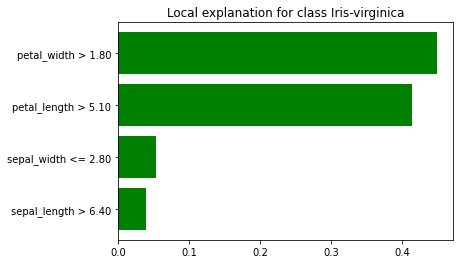

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
118,7.7,2.6,6.9,2.3,Iris-virginica


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))

[0.0, 0.0, 1.0]
[-0.029228320252791706, 0.009674271189799133, 1.0195540490629929]
[0.0, 0.009399539, 0.9906004]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.07950494 0.05651607 0.02547618]
MSE on cv-test  set: [0.07961066 0.05659095 0.02550345]
std on cv-test  set: [0.00299643 0.00265577 0.0011958 ]


In [11]:
explanation.get_losses_for_cv_model(out="raw")

array([[0.08055597, 0.08458494, 0.07680201, 0.07986188, 0.07624848],
       [0.05676951, 0.06041319, 0.05564599, 0.05780733, 0.05231875],
       [0.02485539, 0.02355086, 0.02701425, 0.0261911 , 0.02590563]])

In [12]:
explanation.get_fidelity_loss_on_kfold("raw")

array([0.05406021, 0.05617808, 0.05314634, 0.05461261, 0.05148596])

In [13]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(3, 0.45003632936735255),
 (2, 0.41497567794302964),
 (1, 0.052522864996850854),
 (0, 0.03914453146509083)]

In [14]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, -0.24613841661911406),
 (3, -0.21001855738414463),
 (0, -0.03365678653115458),
 (1, -0.022150823534390292)]

In [15]:
explanation.as_map()

{0: [(3, -0.2400177719832078),
  (2, -0.16883726132391552),
  (1, -0.03037204146246054),
  (0, -0.00548774493393628)],
 1: [(2, -0.24613841661911406),
  (3, -0.21001855738414463),
  (0, -0.03365678653115458),
  (1, -0.022150823534390292)],
 2: [(3, 0.45003632936735255),
  (2, 0.41497567794302964),
  (1, 0.052522864996850854),
  (0, 0.03914453146509083)]}

In [16]:
explainer.discretizer.names

{0: ['sepal_length <= 5.10',
  '5.10 < sepal_length <= 5.80',
  '5.80 < sepal_length <= 6.40',
  'sepal_length > 6.40'],
 1: ['sepal_width <= 2.80',
  '2.80 < sepal_width <= 3.00',
  '3.00 < sepal_width <= 3.30',
  'sepal_width > 3.30'],
 2: ['petal_length <= 1.60',
  '1.60 < petal_length <= 4.30',
  '4.30 < petal_length <= 5.10',
  'petal_length > 5.10'],
 3: ['petal_width <= 0.30',
  '0.30 < petal_width <= 1.30',
  '1.30 < petal_width <= 1.80',
  'petal_width > 1.80']}

In [17]:
explainer.discretizer.maxs

{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.3, 5.1, 6.7],
 3: [0.3, 1.3, 1.8, 2.5]}

Update some attributes to see if probabilities would change

In [18]:
top_features = explanation.as_map()[predicted_label_id]
top_features

[(3, 0.45003632936735255),
 (2, 0.41497567794302964),
 (1, 0.052522864996850854),
 (0, 0.03914453146509083)]